<a href="https://colab.research.google.com/github/DaHyeonnn/paper/blob/master/MyDenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import packages
# from quickdraw import QuickDrawData, QuickDrawDataGroup
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
import pandas as pd
import random

In [3]:
!ls -1ha kaggle.json #확인

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d vencerlanz09/sea-animals-image-dataste #데이터셋 다운

100% 312M/312M [00:09<00:00, 34.8MB/s]
100% 312M/312M [00:09<00:00, 33.7MB/s]


In [6]:
#zip 풀어주기 !
!unzip /content/sea-animals-image-dataste.zip -d /content/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/data/Seahorse/9891995103_849905035f_o.jpg  
  inflating: /content/data/Seahorse/9984393_fb8ac77d6a_o.jpg  
  inflating: /content/data/Seahorse/Sea Horse (1).jpg  
  inflating: /content/data/Seahorse/Sea Horse (10).jpg  
  inflating: /content/data/Seahorse/Sea Horse (11).jpg  
  inflating: /content/data/Seahorse/Sea Horse (12).jpg  
  inflating: /content/data/Seahorse/Sea Horse (13).jpg  
  inflating: /content/data/Seahorse/Sea Horse (14).jpg  
  inflating: /content/data/Seahorse/Sea Horse (15).jpg  
  inflating: /content/data/Seahorse/Sea Horse (16).jpg  
  inflating: /content/data/Seahorse/Sea Horse (17).jpg  
  inflating: /content/data/Seahorse/Sea Horse (18).jpg  
  inflating: /content/data/Seahorse/Sea Horse (19).jpg  
  inflating: /content/data/Seahorse/Sea Horse (2).jpg  
  inflating: /content/data/Seahorse/Sea Horse (20).jpg  
  inflating: /content/data/Seahorse/Sea Horse (21).jpg  
  inflating: /content/data/Seahorse/Sea

In [7]:
#너무 많은 클래스 => 개수 비슷한 클래스 5개만 남겨주자
import shutil
shutil.rmtree('/content/data/Clams')
shutil.rmtree('/content/data/Corals')
shutil.rmtree('/content/data/Crabs')
shutil.rmtree('/content/data/Eel')
shutil.rmtree('/content/data/Otter')
shutil.rmtree('/content/data/Jelly Fish')
shutil.rmtree('/content/data/Lobster')
shutil.rmtree('/content/data/Nudibranchs')
shutil.rmtree('/content/data/Seal')
shutil.rmtree('/content/data/Squid')
shutil.rmtree('/content/data/Puffers')
shutil.rmtree('/content/data/Sea Rays')
shutil.rmtree('/content/data/Sea Urchins')
shutil.rmtree('/content/data/Dolphin')
shutil.rmtree('/content/data/Turtle_Tortoise')
shutil.rmtree('/content/data/Whale')
shutil.rmtree('/content/data/Sharks')
shutil.rmtree('/content/data/Octopus')

In [8]:
import os
!pwd
%cd /content/data/Shrimp
print("Shrimp",len(os.listdir()))

%cd /content/data/Fish
print("Fish",len(os.listdir()))

%cd /content/data/Penguin
print("Penguin",len(os.listdir()))

%cd /content/data/Seahorse/
print("Seahorse",len(os.listdir()))

%cd /content/data/Starfish/
print("Starfish",len(os.listdir()))


/content
/content/data/Shrimp
Shrimp 488
/content/data/Fish
Fish 494
/content/data/Penguin
Penguin 482
/content/data/Seahorse
Seahorse 478
/content/data/Starfish
Starfish 499


In [9]:
## train / val 분류해주기
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# 0.8:0.2 비율로 데이터 분리해줌
import splitfolders
input_folder = "/content/data"
output_folder = "/content/output"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2), group_prefix=None)

Copying files: 2441 files [00:00, 4132.85 files/s]


In [11]:
import torch
import torchvision
from torchvision import transforms

# 데이터셋 클래스 정의
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])      
        ])
        if transform:
            self.transform = transform
        
        self.img_list = []
        self.label_list = []
        self.class_dict = {"Fish": 0, "Penguin": 1, "Seahorse": 2, "Shrimp": 3, "Starfish": 4}

        for class_name in os.listdir(data_dir):
            class_path = os.path.join(data_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.img_list.append(img_path)
                    self.label_list.append(self.class_dict[class_name])
                    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        label = self.label_list[idx]
        
        return img, label

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #이미지의 밝기, 채도 등을 무작위로 변경하는 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 객체 생성
train_data = MyDataset('/content/output/train', transform=transform_train)
val_data = MyDataset('/content/output/val')

# 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True) #랜덤으로 32개씩 배치 생성
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)


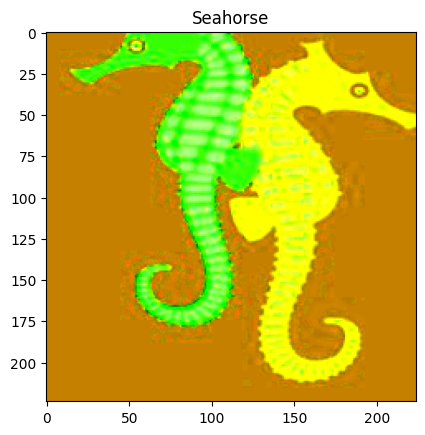

In [12]:
## img, label 출력하기

from PIL import Image
import matplotlib.pyplot as plt
class_dict = {0: "Fish", 1: "Penguin", 2: "Seahorse", 3: "Shrimp", 4: "Starfish"}
img, label = next(iter(train_loader))

fig, ax = plt.subplots()
plt.imshow(img[3].permute(1,2,0))   #image
plt.title(class_dict[label[3].item()])
plt.show()

# DenseNet 구현해보자 !

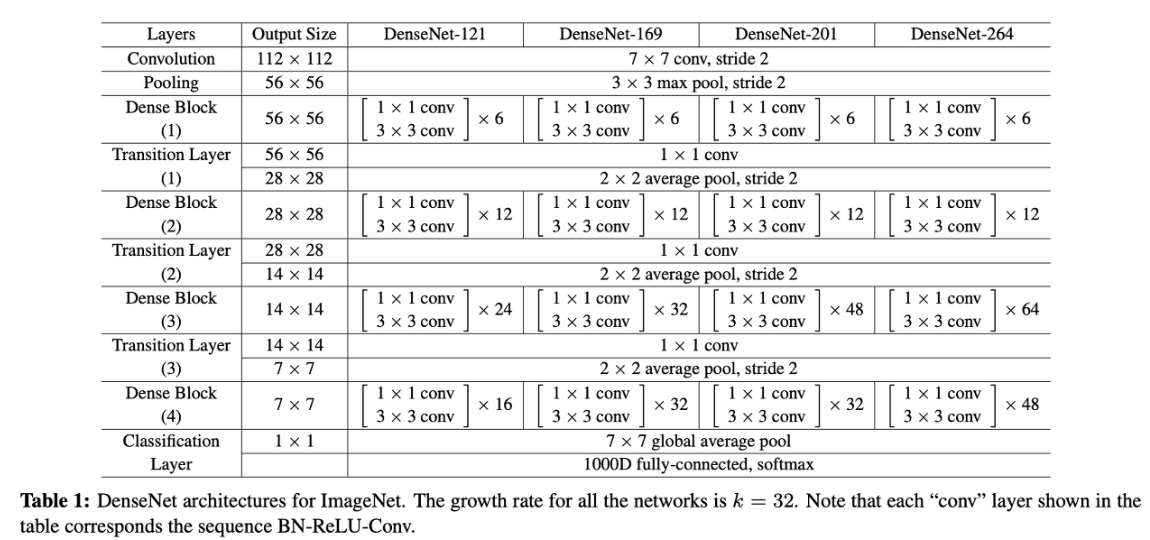


참고 : https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/densenet.py


In [13]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, norm="bnorm", relu=True):
        super().__init__()

        layers = []
        
        if norm == "bnorm":
            layers += [nn.BatchNorm2d(num_features=in_channels)]  

        if relu:
            layers += [nn.ReLU()]

        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                             kernel_size=kernel_size, stride=stride, padding=padding,
                             bias=bias)]
        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)



In [14]:
class DenseBlock(nn.Module): ### denseblock 수행
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        self.bottle_neck = nn.Sequential(
            ConvBlock(in_channels, inner_channel, 1, 1, 0, False, "bnorm", True), # bn -> relu -> 1*1 conv
            ConvBlock(inner_channel, growth_rate, 3, 1, 1, False, "bnorm", True)  # bn -> relu -> 3*3 conv
        )
    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1) #이어 붙이기

In [15]:

class TransLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.trans_layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.trans_layer(x)



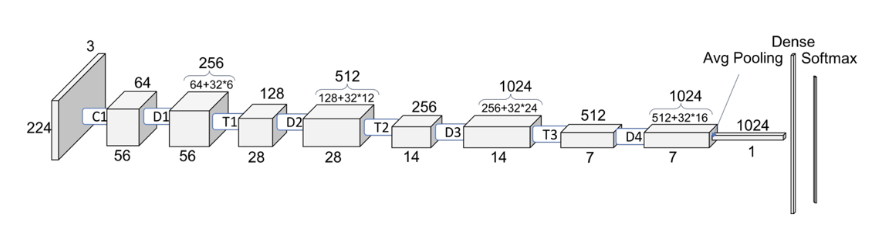

https://wikidocs.net/163753 #growth rate로 레이어 수 계산하기

In [19]:
class MydenseNet121(nn.Module): #densenet121 구현 
    def __init__(self,in_channels, out_channels, growth_rate=32, reduction=0.5, num_class=5, nblk=[6,12,24,16]):
        super(MydenseNet121, self).__init__()
        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate  #concat해주니깐 x2(이전 입력+현재 입력)로 차원을 맞춰줌
     
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #채널 수 변경 x

        inc = 64
        layer1 = []
        for i in range(nblk[0]): #dense Block 1번  
            r = inc + growth_rate * (i)
            denseB_1 = DenseBlock(r, growth_rate)
            layer1 += [denseB_1] 
        self.dense_Block1 = nn.Sequential(*layer1)
        trans_1 = TransLayer(256, 128)
        self.trans_1 = nn.Sequential(trans_1)

        inc = 64*2
        layer2 = []
        for i in range(nblk[1]): #dense Block 2번  
            r = inc + growth_rate * (i)
            dense_block_2 = DenseBlock(r, growth_rate) 
            layer2 += [dense_block_2]  
        self.dense_Block2 = nn.Sequential(*layer2)
        trans_2 = TransLayer(512, 256)
        self.trans_2 = nn.Sequential(trans_2)

        inc = 64*2*2
        layer3 = []
        for i in range(nblk[2]): #dense Block 3번  
            r = inc + growth_rate * (i)
            dense_block_3 = DenseBlock(r, growth_rate)  
            layer3 += [dense_block_3]  
        self.dense_Block3 = nn.Sequential(*layer3)
        trans_3 = TransLayer(1024, 512)
        self.trans_3 = nn.Sequential(trans_3)
        
        inc = 64*2*2*2
        layer4 = []
        for i in range(nblk[3]): #dense Block 4번  
            r = inc + growth_rate * (i)
            dense_block_4 = DenseBlock(r, growth_rate)  
            layer4 += [dense_block_4]  
        self.dense_Block4 = nn.Sequential(*layer4)

        ##classification layer
        self.avg_pool = nn.AvgPool2d(kernel_size=7)
        self.linear = nn.Linear(1024, num_class)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.max_pool1(x)
        
        x = self.dense_Block1(x)
        x = self.trans_1(x)

        x = self.dense_Block2(x)
        x = self.trans_2(x)

        x = self.dense_Block3(x)
        x = self.trans_3(x)

        x = self.dense_Block4(x)
        x = self.avg_pool(x)
        
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out


In [20]:
# check model
x = torch.randn(3, 3,224,224)
my_dense_model = MydenseNet121(3,5)
output = my_dense_model(x)
print(output.size())

my_dense_model = my_dense_model.cuda()

torch.Size([3, 5])


In [21]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(my_dense_model, (3, 224, 224), device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
         ConvBlock-8          [-1, 128, 56, 56]               0
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11           [-1, 32, 56, 56]          36,864
        ConvBlock-12           [-1, 32, 56, 56]               0
       DenseBlock-13           [-1, 96, 56, 56]               0
      BatchNorm2d-14           [-1, 96,

In [23]:
my_dense_model = my_dense_model.cuda()

In [24]:
# Loss function and Optimizer
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(my_dense_model.parameters(), lr=1e-4)

In [25]:
log_dir ='./log'

In [26]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# optimizer 정의
optimizer = torch.optim.Adam(my_dense_model.parameters(), lr=0.001)

# 모델 초기화
my_dense_model.apply(reset_weights)


MydenseNet121(
  (enc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dense_Block1): Sequential(
    (0): DenseBlock(
      (bottle_neck): Sequential(
        (0): ConvBlock(
          (cbr): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): ConvBlock(
          (cbr): Sequential(
            (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
      )
    )


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image

# 구현한 모델 불러옴
my_dense_model.train()
num_classes = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_dense_model.to(device)

# 손실 함수와 옵티마이저 생성
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_dense_model.parameters(), lr=0.001)
num_epochs = 60     #데이터 양이 적어서 60으로 설정
my_val_accuracies = []

# 학습 수행
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    total_train = 0
    total_val = 0
    correct_train = 0
    correct_val = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = my_dense_model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        total_train += len(labels)
        correct_train += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_loader)
    train_acc = running_corrects.double() / total_train

    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = my_dense_model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item()
            val_running_corrects += torch.sum(preds == labels.data)
            total_val += len(labels)
            correct_val += torch.sum(preds == labels.data)
            
    val_loss = val_running_loss / len(val_loader)
    val_acc = val_running_corrects.double() / total_val
    my_val_accuracies.append(val_acc)

    # 매 에폭마다 손실과 정확도 출력
    print('Epoch %d: Train Loss: %.4f Train Acc: %.4f Val Loss: %.4f Val Acc: %.4f' %
          (epoch + 1, train_loss, train_acc, val_loss, val_acc))

print('Finished Training')


Epoch 1: Train Loss: 1.6330 Train Acc: 0.3168 Val Loss: 1.6200 Val Acc: 0.3204
Epoch 2: Train Loss: 1.4761 Train Acc: 0.3670 Val Loss: 1.4400 Val Acc: 0.3143
Epoch 3: Train Loss: 1.3871 Train Acc: 0.3778 Val Loss: 1.3899 Val Acc: 0.3796
Epoch 4: Train Loss: 1.3661 Train Acc: 0.3865 Val Loss: 1.3423 Val Acc: 0.4612
Epoch 5: Train Loss: 1.3442 Train Acc: 0.4034 Val Loss: 1.3186 Val Acc: 0.4265
Epoch 6: Train Loss: 1.3395 Train Acc: 0.4162 Val Loss: 1.3238 Val Acc: 0.4490
Epoch 7: Train Loss: 1.3120 Train Acc: 0.4470 Val Loss: 1.3559 Val Acc: 0.4082
Epoch 8: Train Loss: 1.2898 Train Acc: 0.4346 Val Loss: 1.3425 Val Acc: 0.4449
Epoch 9: Train Loss: 1.2679 Train Acc: 0.4690 Val Loss: 1.2966 Val Acc: 0.4653
Epoch 10: Train Loss: 1.2773 Train Acc: 0.4700 Val Loss: 1.2772 Val Acc: 0.4653
Epoch 11: Train Loss: 1.2790 Train Acc: 0.4572 Val Loss: 1.3100 Val Acc: 0.4592
Epoch 12: Train Loss: 1.2137 Train Acc: 0.4972 Val Loss: 1.2318 Val Acc: 0.4898
Epoch 13: Train Loss: 1.2092 Train Acc: 0.4992 Va

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image

# densenet 모델 불러옴
model = models.densenet121(pretrained=False)
num_classes = 5
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# GPU 사용 가능한 경우 GPU로 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# 모델 초기화
model.apply(reset_weights)

# 손실 함수와 옵티마이저 생성
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 60
real_val_accuracies = [] # 에폭별 val acc 저장
# 학습 수행
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    total_train = 0
    total_val = 0
    correct_train = 0
    correct_val = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        total_train += len(labels)
        correct_train += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_loader)
    train_acc = running_corrects.double() / total_train

    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item()
            val_running_corrects += torch.sum(preds == labels.data)
            total_val += len(labels)
            correct_val += torch.sum(preds == labels.data)
            
    val_loss = val_running_loss / len(val_loader)
    val_acc = val_running_corrects.double() / total_val
    real_val_accuracies.append(val_acc) #그래프에 그리기 위해 추가해줌

    # 매 에폭마다 손실과 정확도 출력
    print('Epoch %d: Train Loss: %.4f Train Acc: %.4f Val Loss: %.4f Val Acc: %.4f' %
          (epoch + 1, train_loss, train_acc, val_loss, val_acc))

print('Finished Training')


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss: 1.4606 Train Acc: 0.3588 Val Loss: 1.4199 Val Acc: 0.4000
Epoch 2: Train Loss: 1.3617 Train Acc: 0.4090 Val Loss: 1.4113 Val Acc: 0.4020
Epoch 3: Train Loss: 1.3601 Train Acc: 0.4280 Val Loss: 1.3357 Val Acc: 0.4388
Epoch 4: Train Loss: 1.3334 Train Acc: 0.4177 Val Loss: 1.3695 Val Acc: 0.4122
Epoch 5: Train Loss: 1.3234 Train Acc: 0.4331 Val Loss: 1.3536 Val Acc: 0.4347
Epoch 6: Train Loss: 1.3213 Train Acc: 0.4346 Val Loss: 1.3627 Val Acc: 0.4551
Epoch 7: Train Loss: 1.3340 Train Acc: 0.4136 Val Loss: 1.3212 Val Acc: 0.4755
Epoch 8: Train Loss: 1.2842 Train Acc: 0.4495 Val Loss: 1.2238 Val Acc: 0.5163
Epoch 9: Train Loss: 1.2575 Train Acc: 0.4726 Val Loss: 1.2549 Val Acc: 0.4673
Epoch 10: Train Loss: 1.2642 Train Acc: 0.4628 Val Loss: 1.2825 Val Acc: 0.5041
Epoch 11: Train Loss: 1.2511 Train Acc: 0.4762 Val Loss: 1.2356 Val Acc: 0.5245
Epoch 12: Train Loss: 1.2262 Train Acc: 0.5008 Val Loss: 1.2030 Val Acc: 0.5286
Epoch 13: Train Loss: 1.1980 Train Acc: 0.5110 Va

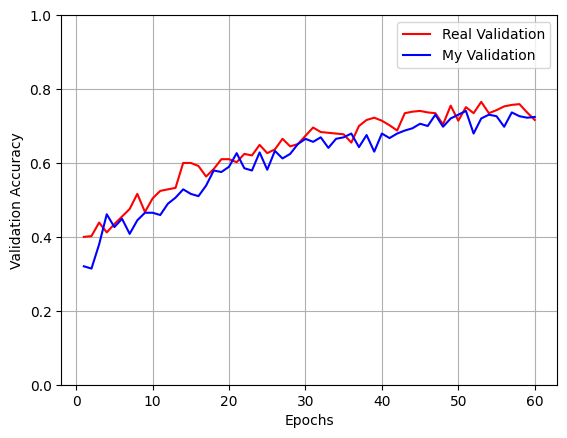

In [29]:

import matplotlib.pyplot as plt

# 그래프 그리기
real_val_accuracies = [x.cpu() for x in real_val_accuracies]
my_val_accuracies = [x.cpu() for x in my_val_accuracies]
plt.plot(range(1, num_epochs+1), real_val_accuracies, 'r', label='Real Validation')
plt.plot(range(1, num_epochs+1), my_val_accuracies, 'b', label='My Validation')

# 축 라벨링
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
# 축 범위 설정
plt.ylim(0, 1)
plt.grid()
plt.legend()

plt.show()
